# Laboratorium Nr 3
Zadaniem dla zespołów jest przeprowadzenie analizy danych i próba odpowiedzi na pytanie:„Czy na podstawie danych z ostatnich 24 lat można wyciągnąć wnioski na temat ocieplenia klimatu?”

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import pyodbc
from sqlalchemy import create_engine, text
from scipy.stats import linregress

## Przygotowanie danych

In [3]:
load_dotenv()

True

In [4]:

login = os.getenv("LOGIN")
password = os.getenv("PASSWORD")
db_host = os.getenv("DB_HOST")
port = os.getenv("PORT")
database = os.getenv("DB_NAME")

In [5]:
conn_str = (
    f"mssql+pyodbc://{login}:{password}@{db_host},{port}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
)


In [6]:
engine = create_engine(conn_str)

In [7]:
query_depesze = text("""
        SELECT idstacji, Data, TemperaturaPowietrza, WysokoscOpadu, CisnienieNaPoziomieStacji
        FROM Synop.dbo.Depesze as depesze
        WHERE depesze.Data BETWEEN '2000-01-01' and '2025-01-01'
    """)



In [8]:
query_stacje = text("""
        SELECT IDStacji, Nazwa, Wojewodztwo, Szerokosc, Dlugosc, Wysokosc
        FROM  Synop.dbo.Stacje as stacje
        WHERE stacje.Kraj = 'Poland'
    """)


In [9]:
""" 
with engine.connect() as conn:
    df_depesze = pd.read_sql(query_depesze, conn)
"""


' \nwith engine.connect() as conn:\n    df_depesze = pd.read_sql(query_depesze, conn)\n'

In [10]:
#df_depesze.to_csv('depesze_output.csv', encoding='utf-8')

In [13]:
df_depesze = pd.read_csv('depesze_output.csv')

In [14]:

with engine.connect() as conn:
    df_stacje = pd.read_sql(query_stacje, conn)

In [16]:
df_merged = df_depesze.merge(df_stacje, left_on="idstacji", right_on="IDStacji", how="left")

In [17]:
df_merged = df_merged.drop(columns=["IDStacji", "idstacji"])

In [79]:
df_merged.head(5)


,Unnamed: 0,Data,TemperaturaPowietrza,WysokoscOpadu,CisnienieNaPoziomieStacji,Nazwa,Wojewodztwo,Szerokosc,Dlugosc,Wysokosc
0,0,2000-04-13,7.7,0.0,980.2,Łódź,łódzkie,51.727400,19.403068,187.0
1,1,2000-04-13,8.0,0.0,980.5,Sulejów,łódzkie,51.354039,19.876077,188.0
2,2,2000-04-13,9.8,0.0,988.1,Kozienice,mazowieckie,51.564827,21.542642,107.0
3,3,2000-04-13,10.1,0.0,974.9,Lublin,lubelskie,51.218023,22.395899,238.0
4,4,2000-04-13,11.8,0.0,982.1,Włodawa,lubelskie,51.550971,23.536622,177.0


In [78]:
df_merged.describe()

,Unnamed: 0,TemperaturaPowietrza,WysokoscOpadu,CisnienieNaPoziomieStacji,Wysokosc
count,1.270889e+07,1.270878e+07,1.270889e+07,1.270889e+07,1.270889e+07
mean,6.354446e+06,8.940766e+00,1.278610e-01,9.067828e+02,1.975001e+02
std,3.668742e+06,8.813644e+00,2.387944e+00,2.778723e+02,3.040370e+02
min,0.000000e+00,-9.820000e+01,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.177223e+06,2.300000e+00,0.000000e+00,9.818000e+02,7.200000e+01
50%,6.354446e+06,8.700000e+00,0.000000e+00,9.955000e+02,1.330000e+02
75%,9.531670e+06,1.550000e+01,0.000000e+00,1.005900e+03,2.050000e+02
max,1.270889e+07,9.600000e+01,9.880000e+02,1.099900e+03,1.991000e+03


## Czyścimy dane

In [20]:
df = df_merged.copy()
df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year
df["Miesiąc"] = df["Data"].dt.month

In [21]:
df = df[df["TemperaturaPowietrza"].notnull()]

In [77]:
# Liczba wierszy z brakującymi danymi  w każdej kolumnie
df.isnull().sum()


Unnamed: 0                   0
Data                         0
TemperaturaPowietrza         0
WysokoscOpadu                0
CisnienieNaPoziomieStacji    0
Nazwa                        2
Wojewodztwo                  2
Szerokosc                    2
Dlugosc                      2
Wysokosc                     2
Rok                          0
Miesiąc                      0
Sezon                        0
dtype: int64

In [ ]:

print(df['TemperaturaPowietrza'].max())

96.0


In [53]:
print(df['TemperaturaPowietrza'].min())

-98.2


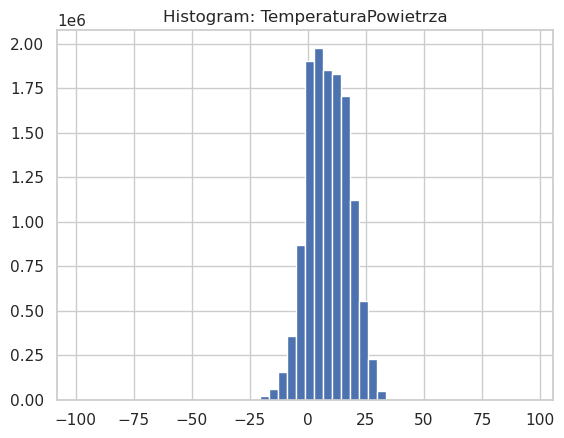

In [47]:
#  Wykres do wykrywania outlierów

df["TemperaturaPowietrza"].hist(bins=50)
plt.title("Histogram: TemperaturaPowietrza")
plt.show()


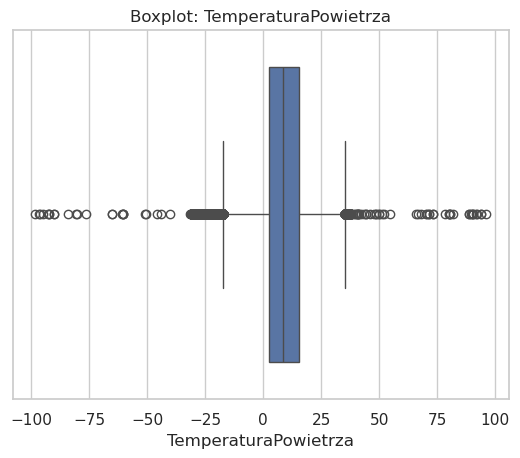

In [48]:
sns.boxplot(x=df["TemperaturaPowietrza"])
plt.title("Boxplot: TemperaturaPowietrza")
plt.show()

In [49]:
Q1 = df["TemperaturaPowietrza"].quantile(0.25)
Q3 = df["TemperaturaPowietrza"].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[
    (df["TemperaturaPowietrza"] >= Q1 - 1.5 * IQR) &
    (df["TemperaturaPowietrza"] <= Q3 + 1.5 * IQR)
]

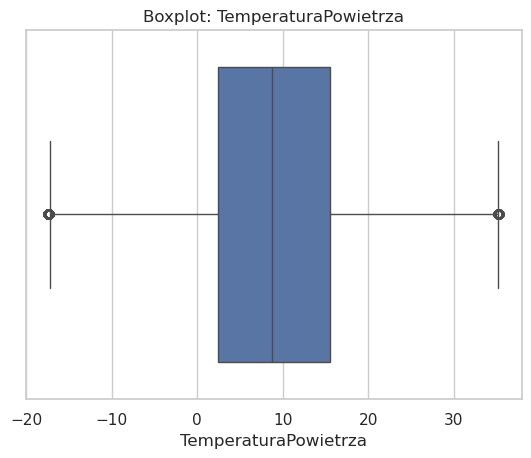

In [50]:
sns.boxplot(x=df_no_outliers["TemperaturaPowietrza"])
plt.title("Boxplot: TemperaturaPowietrza")
plt.show()

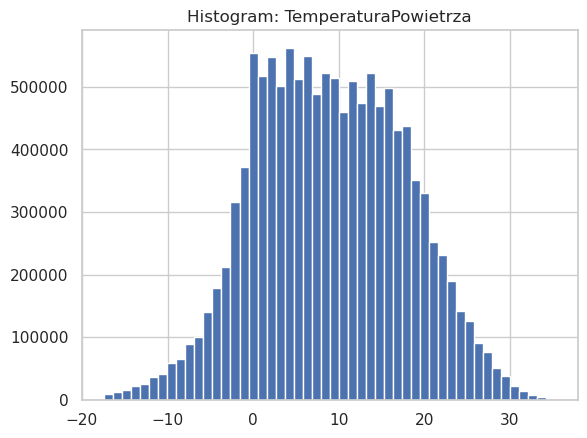

In [51]:
df_no_outliers["TemperaturaPowietrza"].hist(bins=50)
plt.title("Histogram: TemperaturaPowietrza")
plt.show()

In [88]:
df = df_no_outliers.copy()

In [89]:
df['Wojewodztwo'].unique()

array(['łódzkie', 'mazowieckie', 'lubelskie', 'dolnośląskie', 'opolskie',
       'śląskie', 'małopolskie', 'świętokrzyskie', 'podkarpackie',
       'zachodniopomorskie', 'pomorskie', 'warmińsko-mazurskie',
       'podlaskie', 'wielkopolskie', 'kujawsko-pomorskie', 'lubuskie', '',
       nan], dtype=object)

In [90]:
df = df[df['Wojewodztwo'].notnull()]

In [91]:
df = df[df['Wojewodztwo'] != '']

In [93]:
df['Wojewodztwo'].unique()

array(['łódzkie', 'mazowieckie', 'lubelskie', 'dolnośląskie', 'opolskie',
       'śląskie', 'małopolskie', 'świętokrzyskie', 'podkarpackie',
       'zachodniopomorskie', 'pomorskie', 'warmińsko-mazurskie',
       'podlaskie', 'wielkopolskie', 'kujawsko-pomorskie', 'lubuskie'],
      dtype=object)

### Dodatkowe kolumny

In [94]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Zima"
    elif month in [3, 4, 5]:
        return "Wiosna"
    elif month in [6, 7, 8]:
        return "Lato"
    else:
        return "Jesień"

df["Sezon"] = df["Miesiąc"].apply(get_season)

In [95]:
df.head(5)

,Unnamed: 0,Data,TemperaturaPowietrza,WysokoscOpadu,CisnienieNaPoziomieStacji,Nazwa,Wojewodztwo,Szerokosc,Dlugosc,Wysokosc,Rok,Miesiąc,Sezon
0,0,2000-04-13,7.7,0.0,980.2,Łódź,łódzkie,51.727400,19.403068,187.0,2000,4,Wiosna
1,1,2000-04-13,8.0,0.0,980.5,Sulejów,łódzkie,51.354039,19.876077,188.0,2000,4,Wiosna
2,2,2000-04-13,9.8,0.0,988.1,Kozienice,mazowieckie,51.564827,21.542642,107.0,2000,4,Wiosna
3,3,2000-04-13,10.1,0.0,974.9,Lublin,lubelskie,51.218023,22.395899,238.0,2000,4,Wiosna
4,4,2000-04-13,11.8,0.0,982.1,Włodawa,lubelskie,51.550971,23.536622,177.0,2000,4,Wiosna


In [96]:
df.columns

Index(['Unnamed: 0', 'Data', 'TemperaturaPowietrza', 'WysokoscOpadu',
       'CisnienieNaPoziomieStacji', 'Nazwa', 'Wojewodztwo', 'Szerokosc',
       'Dlugosc', 'Wysokosc', 'Rok', 'Miesiąc', 'Sezon'],
      dtype='object')

### Agregacja

In [97]:
monthly_by_region = (
    df.groupby(["Rok", "Sezon"])["TemperaturaPowietrza"]
    .mean()
    .reset_index()
)


In [98]:
monthly_by_region.head(5)

,Rok,Sezon,TemperaturaPowietrza
0,2000,Jesień,9.990298
1,2000,Lato,16.666687
2,2000,Wiosna,9.782681
3,2000,Zima,0.926938
4,2001,Jesień,7.631597


## Wizualizacja

In [99]:
df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year
df["Miesiąc"] = df["Data"].dt.month


monthly_avg = (
    df.groupby(["Rok", "Miesiąc"])["TemperaturaPowietrza"]
    .mean()
    .reset_index()
)

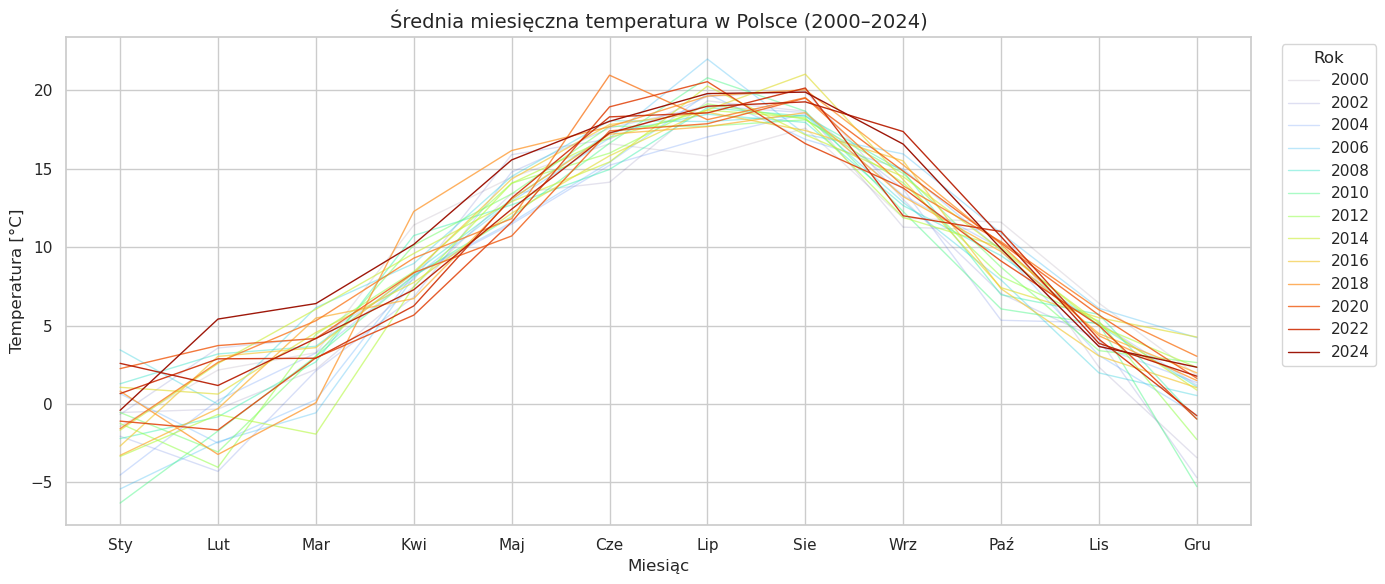

In [100]:
years_sorted = sorted(monthly_avg["Rok"].unique())
n_years = len(years_sorted)
cmap = plt.cm.turbo 

plt.figure(figsize=(14, 6))

for idx, year in enumerate(years_sorted):
    alpha = 0.1 + 0.9 * (idx / (n_years - 1))  # starsze: alpha~0.1, nowsze: ~1
    color = cmap(idx / (n_years - 1))         # kolor zgodnie z wiekiem
    data = monthly_avg[monthly_avg["Rok"] == year]
    
    plt.plot(
        data["Miesiąc"],
        data["TemperaturaPowietrza"],
        label=str(year),
        color=color,
        alpha=alpha,
        linewidth=2 if year >= years_sorted[-1] else 1
    )

# Oś X z nazwami miesięcy
plt.xticks(ticks=range(1, 13), labels=[
    "Sty", "Lut", "Mar", "Kwi", "Maj", "Cze", 
    "Lip", "Sie", "Wrz", "Paź", "Lis", "Gru"
])

plt.title("Średnia miesięczna temperatura w Polsce (2000–2024)", fontsize=14)
plt.xlabel("Miesiąc")
plt.ylabel("Temperatura [°C]")
plt.grid(True)

# Legenda tylko co kilka lat (żeby nie zagracać)
skip = max(n_years // 10, 1)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[::skip], labels[::skip], 
    title="Rok", bbox_to_anchor=(1.02, 1), loc="upper left"
)

plt.tight_layout()
plt.show()



## Dodajemy geodane

Analiza trendu dla poszczególnych województw - regresja liniowa. Analizujemy, jak zmieniała się średnia roczna temperatura co 5 lat.

In [101]:
gdf_woj = gpd.read_file("polska_wojewodztwa.geojson")
gdf_woj["Wojewodztwo"] = gdf_woj["name"].str.lower()

In [102]:
def calculate_trends(df):
    results = []
    for woj, group in df.groupby("Wojewodztwo"):
        if group["Rok"].nunique() < 3:
            continue
        slope, *_ = linregress(group["Rok"], group["TemperaturaPowietrza"])
        trend_per_decade = slope * 5 
        results.append({
            "Wojewodztwo": woj,
            "Trend": round(trend_per_decade, 3)
        })
    return pd.DataFrame(results)


In [103]:
df_trendy = calculate_trends(df)

In [104]:
df_trendy.head(5)

,Wojewodztwo,Trend
0,dolnośląskie,0.361
1,kujawsko-pomorskie,0.341
2,lubelskie,0.365
3,lubuskie,0.371
4,mazowieckie,0.383


In [105]:
gdf_woj = gdf_woj.merge(df_trendy, on="Wojewodztwo", how="left")

In [106]:
gdf_woj.head(5)

,name,geometry,Wojewodztwo,Trend
0,dolnośląskie,"POLYGON ((15 50.5, 17 50.5, 17 51.5, 15 51.5, ...",dolnośląskie,0.361
1,kujawsko-pomorskie,"POLYGON ((18 52.5, 20 52.5, 20 53.5, 18 53.5, ...",kujawsko-pomorskie,0.341
2,lubelskie,"POLYGON ((22 50.5, 24 50.5, 24 51.5, 22 51.5, ...",lubelskie,0.365
3,lubuskie,"POLYGON ((14.5 51.5, 15.5 51.5, 15.5 52.5, 14....",lubuskie,0.371
4,łódzkie,"POLYGON ((19 51, 21 51, 21 52, 19 52, 19 51))",łódzkie,0.239


In [107]:
df_stacje = df.drop_duplicates(subset=["Szerokosc", "Dlugosc"]).copy()

gdf_stacje = gpd.GeoDataFrame(
    df_stacje,
    geometry=gpd.points_from_xy(df_stacje["Dlugosc"], df_stacje["Szerokosc"]),
    crs="EPSG:4326"
)


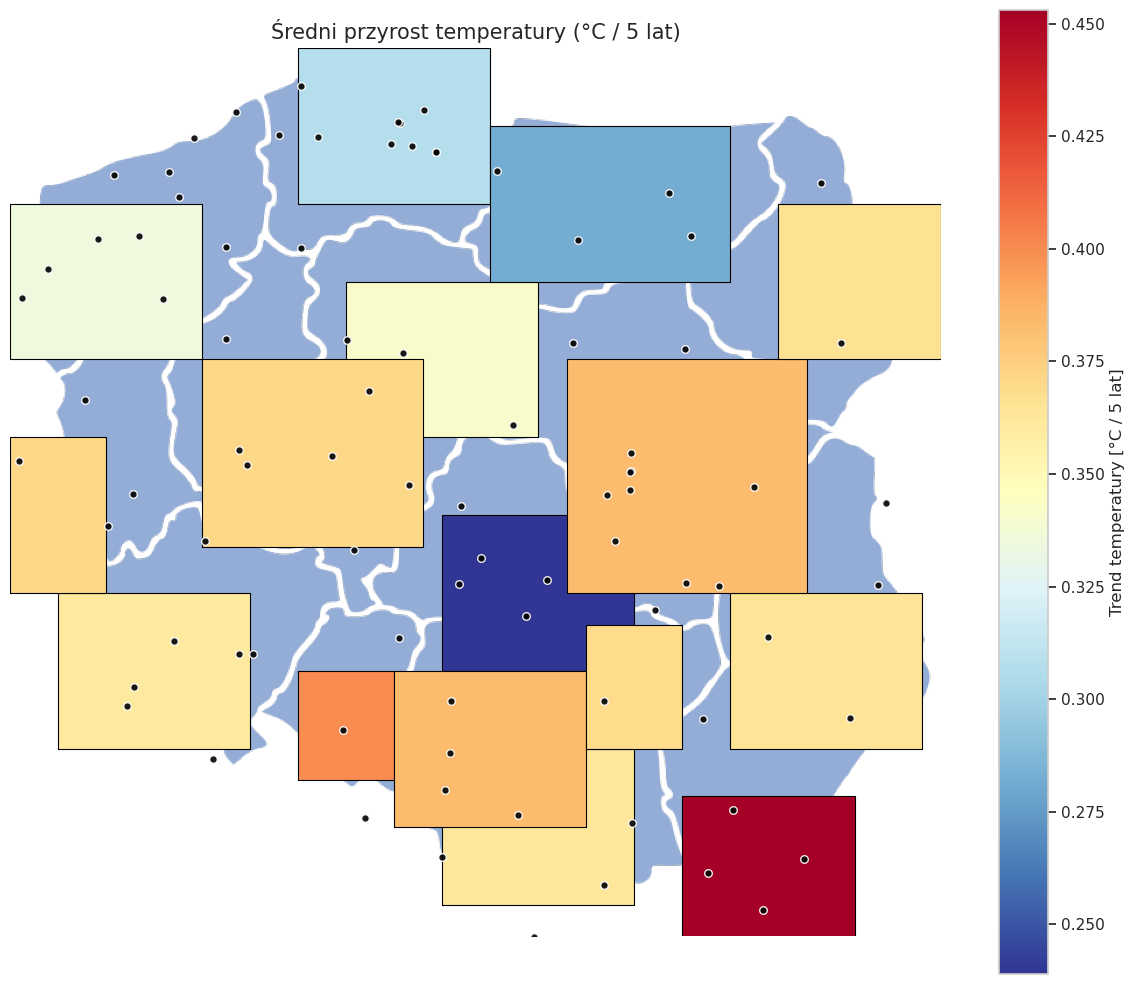

In [108]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

xmin, ymin, xmax, ymax = gdf_woj.total_bounds  

fig, ax = plt.subplots(figsize=(12, 10))

img = mpimg.imread("map.png")
ax.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=0)

gdf_woj.plot(
    ax=ax,
    column="Trend",
    cmap="RdYlBu_r",
    edgecolor="black",
    linewidth=0.8,
    legend=True,
    legend_kwds={'label': "Trend temperatury [°C / 5 lat]"},
    zorder=2  
)

gdf_stacje.plot(
    ax=ax,
    color="black",
    markersize=30,
    alpha=0.9,
    edgecolor="white",
    zorder=3  
)


ax.set_title("Średni przyrost temperatury (°C / 5 lat)", fontsize=15)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.axis("off")
plt.tight_layout()
plt.show()


## Analiza trendu

In [109]:
def calculate_seasonal_trends(df):
    results = []
    grouped = df.groupby(["Wojewodztwo", "Sezon"])
    
    for (woj, sezon), group in grouped:
        if group["Rok"].nunique() < 3:
            continue
        slope, *_ = linregress(group["Rok"], group["TemperaturaPowietrza"])
        trend_per_5 = slope * 5
        results.append({
            "Wojewodztwo": woj,
            "Sezon": sezon,
            "Trend": round(trend_per_5, 3)
        })
    
    return pd.DataFrame(results)

df_sezon_trendy = calculate_seasonal_trends(df)


In [110]:
order = (
    df_sezon_trendy.groupby("Wojewodztwo")["Trend"]
    .mean()
    .sort_values(ascending=False)
    .index
)

In [111]:
seasonal_palette = {
    "Wiosna": "#4CAF50",
    "Lato": "#FFC107",
    "Jesień": "#FF5722",
    "Zima": "#03A9F4"
}

In [112]:
df_sezon_trendy

,Wojewodztwo,Sezon,Trend
0,dolnośląskie,Jesień,0.336
1,dolnośląskie,Lato,0.349
2,dolnośląskie,Wiosna,0.020
3,dolnośląskie,Zima,0.541
4,kujawsko-pomorskie,Jesień,0.316
...,...,...,...
59,śląskie,Zima,0.641
60,świętokrzyskie,Jesień,0.267
61,świętokrzyskie,Lato,0.358
62,świętokrzyskie,Wiosna,0.027


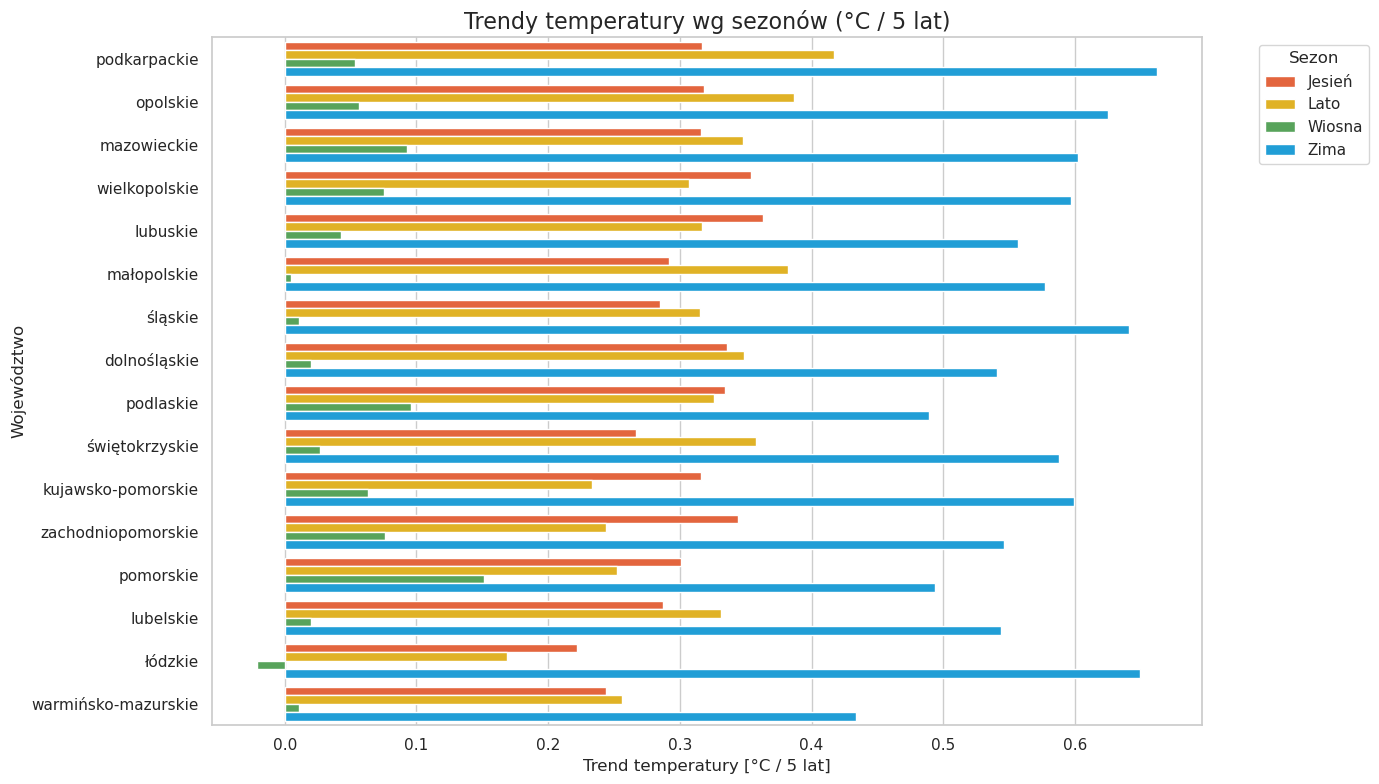

In [114]:

plt.figure(figsize=(14, 8))

sns.barplot(
    data=df_sezon_trendy,
    x="Trend",
    y="Wojewodztwo",
    hue="Sezon",
    order=order,
    palette=seasonal_palette
)

plt.title("Trendy temperatury wg sezonów (°C / 5 lat)", fontsize=16)
plt.xlabel("Trend temperatury [°C / 5 lat]")
plt.ylabel("Województwo")
plt.legend(title="Sezon", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()